In [1]:
import numpy as np                                          
from mindquantum.core.circuit import Circuit                
from mindquantum.core.gates import H, RX, RY, RZ,X    
from mindquantum.core.parameterresolver import PRGenerator  
from mindquantum.simulator import Simulator
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split   
from mindquantum.algorithm.library import amplitude_encoder
from mindquantum.algorithm.nisq import IQPEncoding
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz     
from mindquantum.core.operators import QubitOperator           # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量
import mindspore as ms                                                                         # 导入mindspore库并简写为ms
from mindquantum.framework import MQLayer,MQN2Layer                                              # 导入MQLayer
# 导入HardwareEfficientAnsatz
from mindquantum.core.gates import RY           
import torch
from torchvision import datasets, transforms# 导入量子门RY
from scipy.ndimage import zoom
import random
from data_processing import PCA_data_preprocessing

/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR


In [2]:
# 下载和加载 MNIST 数据集
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
X_train, X_test, y_train, y_test = PCA_data_preprocessing(mnist_dataset)

In [3]:
def amplitude_param(pixels):
    param_rd = []
    _, parameterResolver = amplitude_encoder(pixels, 6)   
    for _, param in parameterResolver.items():
        param_rd.append(param)
    param_rd = np.array(param_rd)
    return param_rd

ç = np.array([amplitude_param(pixels=i.flatten()) for i in X_train])
test_params  = np.array([amplitude_param(pixels=i.flatten()) for i in X_test])
print(f'trian_params shape={trian_params.shape}')

trian_params shape=(963, 126)


In [7]:
amplitude_param(X_train[0])

array([ 1.24420948,  2.15482773,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  2.17896415,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  2.95357866,  0.        ,
        0.        ,  2.80825044,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.23067161,  0.98819686,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.51723684,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.29707684,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  3.14159265,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [20]:
encoder = Circuit()
prg = PRGenerator('alpha')
for index,i in enumerate(X_train[0]):
    encoder +=RX(prg.new()).on(index)
encoder = encoder.as_encoder()
encoder = encoder.no_grad()

ansatz = HardwareEfficientAnsatz(6, single_rot_gate_seq=[RY], entangle_gate=X, depth=2).circuit     # 通过
hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [0,1]]

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(2)                                                     # 设置生成随机数的种子
circuit = encoder+ ansatz.as_ansatz()         
sim = Simulator('mqvector', 10)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit,
                                         parallel_worker=5)
QuantumNet = MQLayer(grad_ops)          # 搭建量子神经网络

In [26]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam                                                  # 导入Adam模块用于定义优化参数
from mindspore.train import Accuracy, Model, LossMonitor                       # 导入Accuracy模块，用于评估预测准确率
import mindspore as ms
from mindspore.dataset import NumpySlicesDataset
from torch.utils.data import DataLoader# 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集



loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            # 通过SoftmaxCrossEntropyWithLogits定义损失函数，sparse=True表示指定标签使用稀疏格式，reduction='mean'表示损失函数的降维方法为求平均值
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.02)                  # 通过Adam优化器优化Ansatz中的参数，需要优化的是Quantumnet中可训练的参数，学习率设为0.1

model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})             # 建立模型：将MindSpore Quantum构建的量子机器学习层和MindSpore的算子组合，构成一张更大的机器学习网络


train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(20) # 通过NumpySlicesDataset创建训练样本的数据集，shuffle=False表示不打乱数据，batch(5)表示训练集每批次样本点有5个
test_loader = NumpySlicesDataset({'features': X_test, 'labels': y_test},shuffle=False).batch(20)                   # 通过NumpySlicesDataset创建测试样本的数据集，batch(5)表示测试集每批次样本点有5个


class StepAcc(ms.Callback):                                                      # 定义一个关于每一步准确率的回调函数
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def on_train_step_end(self, run_context):
        
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])
        # print(f'ACC = {self.acc[-1]}')


monitor = LossMonitor(20)                                                       # 监控训练中的损失，每16步打印一次损失值

acc = StepAcc(model, test_loader)                                               # 使用建立的模型和测试样本计算预测的准确率

model.train(15, train_loader, callbacks=[monitor, acc], dataset_sink_mode=False)# 将上述建立好的模型训练20次

epoch: 1 step: 20, loss is 0.4452002942562103
epoch: 1 step: 40, loss is 0.5341850519180298
epoch: 2 step: 11, loss is 0.6077102422714233
epoch: 2 step: 31, loss is 0.3658744692802429
epoch: 3 step: 2, loss is 0.5749918222427368
epoch: 3 step: 22, loss is 0.38640913367271423
epoch: 3 step: 42, loss is 0.557705819606781
epoch: 4 step: 13, loss is 0.41120418906211853
epoch: 4 step: 33, loss is 0.4632667601108551
epoch: 5 step: 4, loss is 0.4311501085758209
epoch: 5 step: 24, loss is 0.5868632793426514
epoch: 5 step: 44, loss is 0.6380762457847595
epoch: 6 step: 15, loss is 0.4902513921260834
epoch: 6 step: 35, loss is 0.4600283205509186
epoch: 7 step: 6, loss is 0.5212643146514893
epoch: 7 step: 26, loss is 0.5033413171768188
epoch: 7 step: 46, loss is 0.4736659526824951
epoch: 8 step: 17, loss is 0.54118812084198
epoch: 8 step: 37, loss is 0.5225405693054199
epoch: 9 step: 8, loss is 0.6082807183265686
epoch: 9 step: 28, loss is 0.6465954780578613
epoch: 9 step: 48, loss is 0.5953733921

Text(0, 0.5, 'Accuracy')

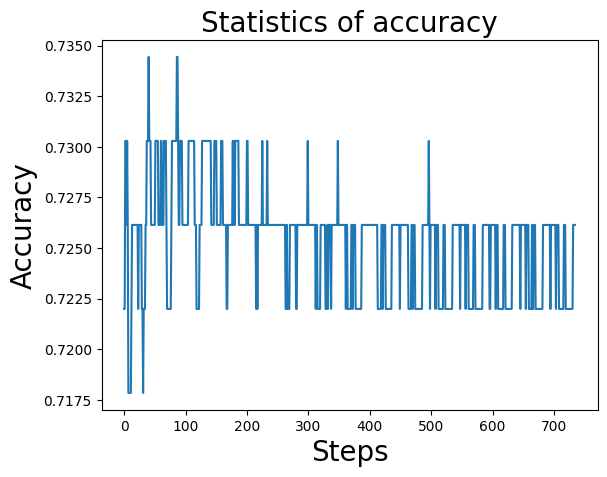

In [27]:
plt.plot(acc.acc)
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)